## Imports

In [23]:
import ast
import inspect
import time
import itertools
from frozendict import frozendict
from IPython.display import display
import graphviz
import inspect
from collections import namedtuple
from typing import Dict, List
from matplotlib import pyplot as plt
%matplotlib inline

## Defining a few function

Let us define a few functions. As we can there is a tree of dependency here.

* a -> b, c
* c -> d

In [2]:
def a():
    return b() + c()

def b():
    return 2

  
def c():
    return d() + 1

def d():
    return 5

funcs = 'abcd'

## Parse the dependency tree

Python is a dynamic laugage that let's us easily see the source of a function, parse source into an AST
and gives us the tools to inspect and manipuate that tree.

Let's take a look at function *a* and see what it depends on.

In [3]:
class Parser(ast.NodeVisitor):
    def __init__(self):
        self.dependency = []

    def generic_visit(self, node):        
        if type(node).__name__ == 'Call':            
            self.dependency.append(node.func.id)            
        ast.NodeVisitor.generic_visit(self, node)
        
p = Parser()
p.visit(ast.parse(inspect.getsource(a)))
p.dependency

['b', 'c']

Okay. That was easy. Now let's get the dependencies of all the functions we're interested in

In [4]:
GraphNode = namedtuple('GraphNode', ['func_name', 'code'])
GraphEdge = namedtuple('GraphEdge', ['node1', 'node2'])

class Graph:
    def __init__(self):
        self.nodes: Dict[str, GraphNode] = {}
        self.edges: List[GraphEdge] = []
        
    def add_node(self, node: GraphNode):
        self.nodes[node.func_name] = node
        

    def add_edge(self, edge: GraphEdge):
        self.edges.append(edge)

g = Graph()

for func_name in funcs:
    func = globals()[func_name]
    code = inspect.getsource(func)
    p = Parser()
    p.visit(ast.parse(code))
    g.add_node(GraphNode(func_name, code))
    for dep in p.dependency:        
        g.add_edge(GraphEdge(func_name, dep))
        
g.edges

[GraphEdge(node1='a', node2='b'),
 GraphEdge(node1='a', node2='c'),
 GraphEdge(node1='c', node2='d')]

## Visualising the tree

Let's use graphviz to show us how the tree looks like

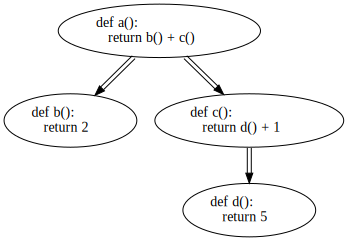

In [5]:
arrow_format = '[color="black:invis:black"]'

def render_node(n: GraphNode):
    code = '\l'.join(n.code.split('\n'))
    return f'{n.func_name} [label="{code}"]'

graph_def = '''digraph D {{   
{nodes}
    
{edges}
}}'''.format(
    nodes = '\n'.join('  ' + render_node(n) for n in g.nodes.values()),
    edges = '\n'.join(f'  {e.node1} -> {e.node2} {arrow_format}' for e in g.edges)
)

display(graphviz.Source(graph_def))

# Next Step

Wow that was easy. However the above overly simplified to help understand what are trying to achieve.

Let's do a few things

1. Create a registry and use a base class to register the nodes
2. Use a decorator to mark the functions that should be part of the node.
3. How about parameters? what if our function *c* was instead

```python
def c(x):
    return d() + x
```

Then surely c(1) and c(2) would be a different node in a grpah. So let's take that into account


## Node and the key

Let's define *GNode* and *GNodeKey* to store the node and the key to the node respectively.

In [6]:
GNode = namedtuple('GNode', ['value', 'children'])
GNodeKey = namedtuple('GNodeKey', ['func', 'args', 'kwargs'])

Now let's define a base class and decorator that would register functions dectorated with *g_func* as nodes

In [ ]:
class Graph:
    def __init__(self):
        self.nodes: Dict[GNodeKey, GNode] = {}
        self.func_defs: Dict[str, str] = {}
            
    def add_node(self, k: GNodeKey, n: GNode):
        self.nodes[k] = n
        
    def is_node(self, func_name: str):
        return func_name in self.func_defs
    
    def get_node(self, k: GNodeKey):
        return self.nodes.get(k)
    
    def add_func_def(self, func_name: str, source: str):
        self.func_defs[func_name] = source
        
    def get_edges(self):
        return list(itertools.chain.from_iterable(
            self._get_edges_for_node(*x) for x in self.nodes.items()))
        
    def _get_edges_for_node(self, k: GNodeKey, n: GNode):
        return [(k.func, x) for x in n.children]
    
graph = Graph()

In [34]:

class GFunc:
    def __init__(self, func):
        self.func = func
        
    def __call__(self, *args, **kwargs):
        return self.func(*args, **kwargs)

def g_func(func):
    p = Parser()
    source = inspect.getsource(func)
    tree = ast.parse(source)
    p.visit(tree)
    func_name = tree.body[0].name

    def f(*args, **kwargs):
        key = GNodeKey(func_name, args, frozendict(kwargs))
        cached_node = graph.get_node(key)
        if cached_node:
            return cached_node.value
        
        graph.add_func_def(func_name, source)
        value = func(*args, **kwargs)
        # filtering by func_defs is a simplication for this notebook
        # this won't work if conditional function has parammeters
        children = [x for x in p.dependency if graph.is_node(x)]
        node = GNode(value, children)
        graph.add_node(key, node)
        return value

    return f
    

def off_graph_func():
    return 1

def expensive_function(x):
    time.sleep(1)
    return x

@g_func
def a():
    return b(x=3) + c(1) + off_graph_func()

@g_func
def b(x=2):
    return x * x

@g_func
def c(x):
    if d() > 0:
        return x * e()
    else:
        return x * f()

@g_func
def d():
    return 5

@g_func
def e():
    return expensive_function(6)

@g_func
def f():
    return expensive_function(7)

In [35]:
%%time

a()

CPU times: user 4.11 ms, sys: 1.72 ms, total: 5.83 ms
Wall time: 1 s


16

In [36]:
%%time

a()

CPU times: user 63 µs, sys: 26 µs, total: 89 µs
Wall time: 98.9 µs


16

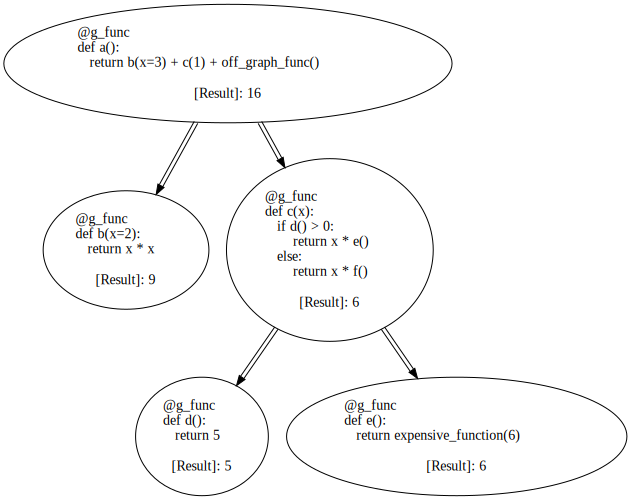

In [28]:
arrow_format = '[color="black:invis:black"]'

def get_edges(k: GNodeKey, n: GNode):
    return '\n'.join(f'  {k.func} -> {x} {arrow_format}' for x in n.children)
                     
def render_node(k: GNodeKey, v: GNode):
    detail = '\l'.join(func_defs[k.func].split('\n'))
    detail += f'\l[Result]: {v.value}'
    return f'{k.func} [label="{detail}"]'

graph_def = '''digraph D {{   
{nodes}
{edges}
}}'''.format(
    nodes = '\n'.join('  ' + render_node(*x) for x in graph.nodes.items()),
    edges = '\n'.join(f'  {n1} -> {n2} {arrow_format}' for n1, n2 in graph.get_edges())
)

display(graphviz.Source(graph_def))